# (guebin) Eearthquake (2)
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

### imports

In [216]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [217]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

### load data and clean it

`-` load

In [218]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


`-` cleaning

In [219]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

3378    1975-02-23T02:58:41.000Z
Name: Date, dtype: object

In [220]:
df.iloc[3378,0] = '02/03/1975'

In [221]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

7512    1985-04-28T02:53:41.530Z
Name: Date, dtype: object

In [222]:
df.iloc[7512,0] = '04/28/1985'

In [223]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object

In [224]:
df.iloc[20650,0] = '03/13/2011'

In [225]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

,Latitude,Longitude,Magnitude,Year
0,19.2460,145.6160,6.0,1965
1,1.8630,127.3520,5.8,1965
2,-20.5790,-173.9720,6.2,1965
3,-59.0760,-23.5570,5.8,1965
4,11.9380,126.4270,5.8,1965
...,...,...,...,...
23407,38.3917,-118.8941,5.6,2016
23408,38.3777,-118.8957,5.5,2016
23409,36.9179,140.4262,5.9,2016
23410,-9.0283,118.6639,6.3,2016


In [226]:
df.Year = df.Year.astype(np.float64)

### define class

In [227]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.5
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [228]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        

### analysis

`-` make instance for analysis

In [229]:
moo=MooYaHo2(df.query("Year == 2016"))

- 테스트용으로 2016년 자료만 수집

`-` get distance 

In [230]:
moo.get_distance()

100%|██████████| 469/469 [00:00<00:00, 1877.07it/s]


In [231]:
moo.D[moo.D>0].mean()

8647.918085847994

- 0이 아닌 거리의 평균은 8600정도?

(array([18438., 25088., 29216., 29204., 30978., 28712., 22932., 17002.,
        13158.,  4764.]),
 array([3.09519959e-01, 1.99516074e+03, 3.99001197e+03, 5.98486319e+03,
        7.97971442e+03, 9.97456564e+03, 1.19694169e+04, 1.39642681e+04,
        1.59591193e+04, 1.79539705e+04, 1.99488218e+04]),
 <BarContainer object of 10 artists>)

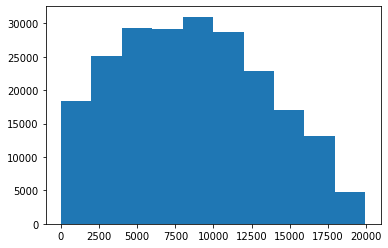

In [232]:
plt.hist(moo.D[moo.D>0])

- 히스토그램결과 -> 2500보다 거리가 작으면 거의 같은 지역이라고 봐도 무방할듯

`-` weight matrix

In [233]:
moo.get_weightmatrix(theta=(8647.92),kappa=2500) 

- 평균적으로 노드는 `np.exp(-(dist/8647)**2)=np.exp(-1)=0.36787944117144233` 정도의 연결강도를 가진다. 
- 거리가 2500이하이면 weight를 1로 설정한다. 

`-` fit

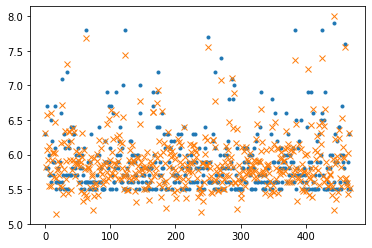

In [234]:
moo.fit2()

In [235]:
moo.df

,Latitude,Longitude,Magnitude,Year,MagnitudeHat,Residual
22943,-50.5575,139.4489,6.3,2016.0,6.309458,-0.009458
22944,-28.6278,-177.2810,5.8,2016.0,5.815040,-0.015040
22945,44.8069,129.9406,5.8,2016.0,6.061400,-0.261400
22946,24.8036,93.6505,6.7,2016.0,6.568068,0.131932
22947,30.6132,132.7337,5.8,2016.0,5.928886,-0.128886
...,...,...,...,...,...,...
23407,38.3917,-118.8941,5.6,2016.0,5.590909,0.009091
23408,38.3777,-118.8957,5.5,2016.0,5.430272,0.069728
23409,36.9179,140.4262,5.9,2016.0,6.024688,-0.124688
23410,-9.0283,118.6639,6.3,2016.0,6.314994,-0.014994


In [236]:
moo.df.query('Magnitude>7')

,Latitude,Longitude,Magnitude,Year,MagnitudeHat,Residual
22969,59.6363,-153.4051,7.1,2016.0,6.710641,0.389359
22976,53.9776,158.5463,7.2,2016.0,7.304112,-0.104112
23005,-4.9521,94.3299,7.8,2016.0,7.685329,0.114671
23066,0.3819,-79.9218,7.8,2016.0,7.433410,0.366590
23116,-56.2409,-26.9353,7.2,2016.0,6.941504,0.258496
23193,18.5429,145.5073,7.7,2016.0,7.559435,0.140565
23203,-22.4765,173.1167,7.2,2016.0,6.782576,0.417424
23213,-55.2852,-31.8766,7.4,2016.0,7.084459,0.315541
23230,-0.0456,-17.8255,7.1,2016.0,7.107971,-0.007971
23326,-42.7358,173.0499,7.8,2016.0,7.370448,0.429552


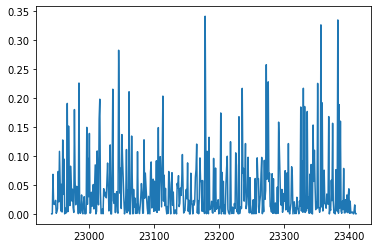

In [237]:
plt.plot((moo.df.Residual)**2)

`-` vis

In [1]:
#moo.vis(MagThresh=7,ResThresh=0.3) # <- 실행해봐요

- 전체자료는 underlying에 위치 
- 지진강도가 MagThresh 이상인 자료는 붉은점으로 시각화함 
- 이상치정도(우리가 제안하는 새로운 메져) ResThresh 이상인 자료는 파란점으로 시각화함 